# Loading Data

Loading data involves *finding* it, and *reading* it. In Nx5d the distinction
is necessary because of the inherent link between experimental data
and [spice](../spice-man/).

Contents:

- [URLs, Handles, Keys](#urls-handles-keys)
- [Subclassing Examples](#subclassing-examples)
  - [Minimal, Purely In-Memory Example](#minimal-purely-in-memory-example)
  - [Filesystem-Based Custom Format](#filesystem-based-custom-format)
  - [H5-Like Array-Based Formats](#h5-like-array-based-formats)


## URLs, Handles, Keys

The first step of *finding* data is, in itself, also a two-step process:
finding the proposal within a repository, and then scan within. 

Nx5d [internally works](../api-guide/#proposals) by referencing data in a
URL style: supported schemes (file, http, s3) are followed by a target document
(server, folder, path to an HDF5) and an document anchor within that document
separated by the rest of the URL by the `#` token (e.g. path within the HDF5
file). The document boundary may be at any level: proposal, or scan.

A typical URL may look like any of these:
- [file:///tmp/drepo/{proposal}/data.h5#{scan}](.)
- [file:///tmp/drepo/{proposal}/{proposal}.h5#{proposal}/{scan}](.)
- [file:///tmp/drepo.hdf#{proposal}/{scan}](.)
- [file:///tmp/drepo/{proposal}/{proposal}-{scan}.h5#data/](.)

URL patterns are required to contain the `{proposal}` and `{scan}`
Python formatting keywords for identifying the actual scan data
payload. Each of the keywords can appear multiple times at any location
in the URL, and the various implementations of the corresponding Nx5d classes
will try to cope :-)

The key-parsing / key-replacing pattern is used, in different ways,
for two distinct tasks:

- generate listings by parsing keys, e.g. of proposals in a repository,
  or scan, in a proposal

- generate references (i.e. URLs) for loading the corresponding
  resource, proposal or scan, by filling keys in.

The information that matches the formatting keys is also called a **key**
in Nx5d -- a *proposal key* for `{proposal}`, respectively *scan key*
for `{scan}`. Nx5d also internally needs to create a **handle** out of each
key. Handles are expected to  be strings that are compatible with Python
symbol naming conventions (i.e. no spaces, no punctuation apart from underscore
"_", first character must be a letter). Both handles and keys are used internally
within the Nx5d API to address resources (scans and proposals). But handles are
*also* used to build more easy-to-use interfaces, where sub-objects like
proposals in a repo, or scans in a proposal, can be accessed by autocompletion
in a suitable environment (e.g. Jupyter).

## Subclassing Examples

Finding and loading data involves work on three levels: repositories, proposals, scans.
Repositories and proposals need to be identified and have their contents listed,
while scans are the "low-level" component that is actually tasked with reading
data from disk. Supporting a data storage format (i.e. a "new beamline") therefore
involves implementing the required unique combination of 3 such classes.
Typically this involves subclassing of either the corresponding components in
`nx5d.repo.base`, or of slightly more specialized classes in `nx5d.repo.filesystem`
or `nx5d.repo.astor`.

We are demonstrating this in several examples.

### Minimal, Purely In-Memory Example

The simplest example is useless in terms of real-world application, but makes the
essential API elements that need implementing easier to understand.

#### A Made-Up Experiment Structure
Here's our minimal
example scenario:

- the proposal is a purely in-memory Python dictionary which contains 3
  hard-coded proposals ("alfa", "bravo", "charlie")

- each proposal has 4 scans, labeled by the first letter and a number from 1 to 4
  (i.e. "a1", "a2", "a3", "a4" for "alpha"'s scans, "b1", "b2", ... for "bravo"'s scans etc)

- the data is a simple Python tuple of strings (proposal, scan).

- the processing, or *cooking* involved, consists only of transforming the strings to upper case.


#### Preparing The "Loading" Code

...actually, we'll be hard-coding the data into the code.

We are subclassing directly from the `nx5d.repo.base` classes:

In [48]:
from nx5d.repo.base import DataScanBase, DataProposalBase, DataRepoBase

The first class we're implementing is the scan class, and we call it `SimpleScan`.
We need to overwrite the `._get_raw()` and `._cook()` functions to simulate loading,
respectively processing. The `._get_summary()` function may seem like a pointless
exercise here, but it's intended for more "heavy use" scenarii: sometimes, when there
are serious amounts of data involved, loading by `._get_raw()` takes time.
Then `._get_summary()` is expected to deliver as many individual details as feasible with
a minimal amount of processing -- just enough to identify main features of the scan
in a (possibly large) listing, but without spending precious time on fully loading
a scan's data.

Here the full class:

In [49]:
class SimpleScan(DataScanBase):
    def __init__(self, parent_proposal, scan_key):
        super().__init__(parent_proposal, scan_key)
        self._parent_prop = parent_proposal 

    def _get_summary(self):
        return {
            'type': 'default_type',
            'description': 'Nonsensical Demo Scan Class'
        }

    def _get_raw(self):
        return (self._parent_prop.key, self.key)

    def _cook(self, data, **spice):
        return tuple([d.upper() for d in data])

The proposal and repository classes are simpler. All they do is hold a static
database (here a `dict()`) in memory, from which they provide listing via `.all()`,
or return an instance of a lower-level object via `._scan()`, respectively `._proposal()`:

In [50]:
class SimpleProposal(DataProposalBase):
    def __init__(self, repo, key):
        self._scans = [ f'{key[0]}{i}' for i in range(4) ]
        super().__init__(repo, key)

    def all(self):
        return { k:k for k in self._scans }

    def _scan(self, scan_key):
        return SimpleScan(self, scan_key)

class SimpleRepository(DataRepoBase):
    def __init__(self):
        self._proposals = [ 'alpha', 'bravo', 'charlie' ]
        super().__init__(url='memory')

    def all(self):
        return { k:k for k in self._proposals }
        
    def _proposal(self, proposal_key):
        return SimpleProposal(self, proposal_key)

#### Simulated "Listing And Loading"

Now we can put our example to the test by initializing a repository, and performing
basic activities we'd perform with "real" data:

In [51]:
simple = SimpleRepository()
simple.all()

{'alpha': 'alpha', 'bravo': 'bravo', 'charlie': 'charlie'}

Generate a scan listing of `simple.alpha`:

In [52]:
simple.alpha

View the raw and cooked data of `simple.alpha.a0`:

In [53]:
print('   raw:', simple.alpha.a0.raw)
print('cooked:', simple.alpha.a0.cooked)

   raw: ('alpha', 'a0')
cooked: ('ALPHA', 'A0')


In essence, we now understand how the API structure works around
"loading" the `a0` scan and viewing its "raw data" -- which is a tuple
of strings, as hard-coded; and its processing form, the upper-case version
of the same strings -- again, as hardcoded.

You're encouraged to retrieve the other scans and/or proposals (`b0`, `c3`, ...)
and convince yourself that our class family works as intended.

### Filesystem-Based Custom Format

This is one of the most likely starting points when supporting a new experimental
endstation: scan data in files, grouped together in a corresponding folder structure
of the kind `proposla/scan/...`.
To demonstrate, let's consider a 
[test data example](https://gitlab.com/kmc3-xpp/nx5d-examples/-/raw/master/data/repo2.tgz).

#### Obtaining And Investigating The Test Data

We download the test repository `repo2` and consider the structure of the repository:

In [7]:
%%bash

# Download and unpack the test data
mkdir -p ~/tmp && cd ~/tmp
curl https://gitlab.com/kmc3-xpp/nx5d-examples/-/raw/master/data/repo2.tgz 2> /dev/null | tar xzf -

# View the folder stucture
find ~/tmp/repo2 -type d -ls

# View the first and last few files (there are ~5200 of them in total...) 
ls -l ~/tmp/repo2/20210205/091726/ | head -n 5
echo ...
ls -l ~/tmp/repo2/20210205/091726/ | tail -n 5

  9806215      0 drwxr-sr-x   1 jovyan   users          16 Oct 11 14:54 /home/jovyan/tmp/repo2
  9806216      0 drwxr-sr-x   1 jovyan   users          12 Oct 11 14:21 /home/jovyan/tmp/repo2/20210205
  9806217      0 drwxr-sr-x   1 jovyan   users      155662 Oct 11 14:53 /home/jovyan/tmp/repo2/20210205/091726
total 21232
-rw-r--r--. 1 jovyan users   2693 Oct 11 14:45 image00000.tiff
-rw-r--r--. 1 jovyan users   2502 Oct 11 14:45 image00001.tiff
-rw-r--r--. 1 jovyan users   2511 Oct 11 14:45 image00002.tiff
-rw-r--r--. 1 jovyan users   2346 Oct 11 14:45 image00003.tiff
...
-rw-r--r--. 1 jovyan users   1594 Oct 11 14:45 image05184.tiff
-rw-r--r--. 1 jovyan users   1642 Oct 11 14:45 image05185.tiff
-rw-r--r--. 1 jovyan users   1464 Oct 11 14:45 image05186.tiff
-rw-r--r--. 1 jovyan users 489989 Oct 11 14:38 manifest.dat
-rw-r--r--. 1 jovyan users    560 Feb  5  2021 parameters.txt


The structure is a simplified version of the UDKM
PXS X-ray data format, essentially made up of:

- a text file called `manifest.dat`, which is a CSV format of sorts with
  a header line, and lots of numbers (about 5200 lines -- one line
  for each data frame), among others scanning angles for \$\omega--2\theta\$ scans
- about 5200 individual detector images, each in its own TIFF file --
  one image for each line of the manifest file.

The contents of the manifest file are a header line that starts with `%` and contains
comlumn names, and many lines (i.e. "frames") with the numbers for each colum. (Note
that we've truncated the lines at ~50 characters in the output below -- this is just to convey an idea
of the file structure):

In [5]:
%%bash

head -n 5 /home/jovyan/tmp/repo2/20210205/091726/manifest.dat | cut -c -50

% Loop_Delay	Delay	Loop_Theta	Theta	Crystal [V]	Crystal [ph/s]	Pilatus
1.000000	-10.000000	1.000000	18.100000	0.500112	1907585.545459	4145.00
1.000000	-10.000000	1.000000	18.150000	0.444915	1684834.053402	2468.00
1.000000	-10.000000	1.000000	18.200000	0.474854	1805655.578219	1534.66
1.000000	-10.000000	1.000000	18.250000	0.481576	1832780.687594	817.000


Later when loading, we will, of course, consider the full file and line length.

#### The Code: Loading And Delegating

As we've seen in the [first exammple](#minimal-purely-in-memory-example), Nx5d is fairly agnostic about
how you treat your data internally. But most of the tools
the Nx5d authors *also* maintain (e.g. [Kmc3recipes](https://gitlab.com/kmc3-xpp/kmc3recipes))
prefer to work with [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html)
flat structures. So that's what we'll do: load all the data in `manifest.dat`, *and* the images one
by one, in one giant xarray Dataset. For that we'll use
[Pandas](https://pandas.pydata.org/), respectively [TiffFile](https://pypi.org/project/tifffile/)
for the heavy lifting. Note that we're skipping all kinds of plausibility tests and error handling
here for the sake of clarity (you obviously shouldn't afford that luxury in a production environment):

In [1]:
def fs_load_data(scan_path, reduce=1):
    '''
    Loads simplified UDKM data from `scan_path` and returns an xarray.Dataset.
    '''
    import pandas, xarray, numpy, tifffile, re
    tab = pandas.read_csv(f'{scan_path}/manifest.dat', sep='\t')
    result = xarray.Dataset({
        re.sub('[][%/ ]', '', k): ('index', tab[k]) for k in tab
    })
    result['images'] = (
        ('index', 'w', 'h'),
        numpy.stack([
            tifffile.imread(f'{scan_path}/image{i:05d}.tiff')[::reduce,::reduce] \
            for i in range(len(tab))
        ])
    )
    return result

Let's risk a peek on how Jupyter sees the data loaded into memory
(to save RAM, we'll use a parameter `reduce` which loads only every i-th
pixel):

In [3]:
example = fs_load_data('/home/jovyan/tmp/repo2/20210205/091726', reduce=10)
example

<xarray.Dataset> Size: 21MB
Dimensions:         (index: 5187, w: 20, h: 49)
Dimensions without coordinates: index, w, h
Data variables:
    Loop_Delay      (index) float64 41kB 1.0 1.0 1.0 1.0 1.0 ... 3.0 3.0 3.0 3.0
    Delay           (index) float64 41kB -10.0 -10.0 -10.0 ... -6.0 -6.0 -6.0
    Loop_Theta      (index) float64 41kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Theta           (index) float64 41kB 18.1 18.15 18.2 ... 19.0 19.05 19.1
    CrystalV        (index) float64 41kB 0.5001 0.4449 0.4749 ... 0.3406 0.2961
    Crystalphs      (index) float64 41kB 1.908e+06 1.685e+06 ... 1.084e+06
    Pilatusphs      (index) float64 41kB 4.145e+03 2.468e+03 ... 150.0 109.7
    Repeats         (index) float64 41kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ImageNumber     (index) float64 41kB 0.0 1.0 2.0 ... 5.185e+03 5.186e+03
    Intensitiesphs  (index) float64 41kB nan nan nan nan nan ... nan nan nan nan
    images          (index, w, h) int32 20MB -2 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0

Armed with this helper function we're ready to build our loading classes arsenal: the Repository, the Proposal
and the Scan class.

To find scans which are represented as sub-foders in a hieararchical filesystem
structure, Nx5d already includes the [`FsDataRepository`](../../api.md#FsDataRepository)
class, respectively [`FsDataProposal`](../../api.md#FsDataProposal). Being able to
fall back on that kind of functionality makes implementation fairly easy.
But in contrast to our simplest exmple we still need
to supply the necessary hey-to-handle translation functions. This is because,
unlinke in our simplest example, the proposal and scan names here (`20210205`, respectively
`091726`) are no valid Python variable names anymore, unless they receive an 
alphabetic letter as their first character (`p`, respectively `r`):

In [2]:
from nx5d.repo.filesystem import DataRepository, DataProposal
from nx5d.repo.base import DataScanBase


class UdkmRepository(DataRepository):
    def __init__(self, url, **kw):
        super().__init__(url, proposal_k2h=lambda x: f'p{x}', **kw)
        
    def _proposal(self, key):
        return UdkmProposal(self, key, self.repo_url)
        

class UdkmProposal(DataProposal):
    def __init__(self, repo, key, scanurl):
        super().__init__(repo,
                         key,
                         url=scanurl,
                         scan_k2h=lambda x: f'r{x}')
       
    def _scan(self, key):
        return UdkmDataScan(self, key)

For the final piece, we'll continue to use the scan base class. By
far the most involved part here is the `._cook(...)` function,
which is as close as feastible to "real-life" data processing based
on [`xrayutilities`](https://xrayutilities.sourceforge.io). Mind that

In [32]:
from nx5d.repo.base import DataScanBase
import glob, urllib, xrayutilities, math, xarray, numpy    

class UdkmDataScan(DataScanBase):
    def _get_raw(self):
        p = urllib.parse.urlparse(self.url)
        return fs_load_data(p.path, reduce=2)
        
    def _get_summary(self):
        p = urllib.parse.urlparse(self.url)
        return {
            'type': 'default',
            'description': 'UDKM simplified example',
            'steps': len(glob.glob(f'{p.path}/*tiff'))
        }

    def _cook(self, data, **spice):

        # preparation "for later"
        cfg = _rsm_settings(**spice)

        img_size = (98, 244)
        
        reduce=2  ## To reduce memmory usage (example only)
    
        qconv = xrayutilities.experiment.QConversion(
            sampleAxis=('y-',), detectorAxis=('y-',), r_i=(1,0,0), en=8048.0
        )
        hxrd = xrayutilities.HXRD(
            qconv=qconv, idir=(1,0,0), ndir=(0,1,0)
        )
        
        hxrd.Ang2Q.init_area(
            'y-', 'z+',  *cfg.img_center, *img_size,
            pwidth1=0.172, pwidth2=0.172, distance=cfg.img_distance
        )
        
        def _per_delay_transform(delay_data):
            delay = data.Delay.mean()
            
            qx, qy, qz = hxrd.Ang2Q.area(
                delay_data.Theta.values, delay_data.Theta.values*2  ## Fake 2-theta
            )
            
            gridder = xrayutilities.FuzzyGridder2D(*cfg.grid_size)
            gridder(qy, qz, delay_data.images.values)
            
            return xarray.Dataset({
                'qdata': (('qy', 'qz'), gridder.data),
                'qy': gridder.xaxis,
                'qz': gridder.yaxis,
            })
    
        return data.groupby('Delay').map(_per_delay_transform)


from collections import namedtuple
RsmSettings = namedtuple('RsmSettings', [
        'img_center', 'grid_size', 'img_distance'
])


def _rsm_settings(**spice):
    # Set some RSM defaults (hard-coded for now, later we'll extract
    # them from spice).

    print('loading hard-coded settings')

    return RsmSettings(
        (45, 150), # img_center
        (80, 150), # grid_size
        680.0      # img_distance
    )

Mind that
many processing parameters in the `UdkmDataScan._cook(...)` above are
hard-coded, although they most certainly shouldn't be in a "real" production
environment: center pixel of the detector,
detector distance, missing \$2\theta\$ angle etc). This is to keep this example
simple. Nonetheless, this is a *perfect and hands-on* example of what the
[spice mechanism](../spice-concept/) was intended for: to provide means
of supplying useful settings to `._cook(...)`. We'll circle back to spice use
at the end of this example.

#### Listing Repository

For now, preparatory steps finished, we can access
the repository using our newly created `UdkmRepository`.
At this level we'll have to specify `url=...` manually.

Working with on-disk spice is not (yet) a goal of this example.
Therefore we're activating a in-memory spice collecting for our `Udkm...` examples
by setting the corresponding to an empty string: `spice_url=''`.

In [33]:
udkm = UdkmRepository(
    url='file:///home/jovyan/tmp/repo2/{proposal}/{scan}',
    spice_url=''
)

Now we can list the repository's proposals (spoiler: there's only one ;-) and we can access the proposal by its handle, `.p20210205`, directly:

In [34]:
udkm.all()

{'20210205': 'p20210205'}

In [35]:
udkm.p20210205

So obviously our code is able to list and find the
scan.


#### Accessing Data

It's time to have the data loaded and displayed:

In [36]:
raw = udkm.p20210205.r091726.raw
raw

<xarray.Dataset> Size: 497MB
Dimensions:         (index: 5187, w: 98, h: 244)
Dimensions without coordinates: index, w, h
Data variables:
    Loop_Delay      (index) float64 41kB 1.0 1.0 1.0 1.0 1.0 ... 3.0 3.0 3.0 3.0
    Delay           (index) float64 41kB -10.0 -10.0 -10.0 ... -6.0 -6.0 -6.0
    Loop_Theta      (index) float64 41kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Theta           (index) float64 41kB 18.1 18.15 18.2 ... 19.0 19.05 19.1
    CrystalV        (index) float64 41kB 0.5001 0.4449 0.4749 ... 0.3406 0.2961
    Crystalphs      (index) float64 41kB 1.908e+06 1.685e+06 ... 1.084e+06
    Pilatusphs      (index) float64 41kB 4.145e+03 2.468e+03 ... 150.0 109.7
    Repeats         (index) float64 41kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ImageNumber     (index) float64 41kB 0.0 1.0 2.0 ... 5.185e+03 5.186e+03
    Intensitiesphs  (index) float64 41kB nan nan nan nan nan ... nan nan nan nan
    images          (index, w, h) int32 496MB -2 0 0 0 0 0 0 ... 0 0 0 0 0 0 -2

The "natural coordinate system" of these data is a reciprocal space
map, i.e. intensity in the Q-space -- one map for each delay point.
With our preparatory work, triggering such a transformation step now
is as easy as accessing the `.cooked` property of the scan:

In [37]:
rsm = udkm.p20210205.r091726.cooked
rsm

loading hard-coded settings


<xarray.Dataset> Size: 12MB
Dimensions:  (Delay: 122, qy: 80, qz: 150)
Coordinates:
  * qy       (qy) float64 640B -0.05364 -0.05237 -0.05111 ... 0.04515 0.04642
  * qz       (qz) float64 1kB 2.386 2.389 2.391 2.394 ... 2.754 2.757 2.759
  * Delay    (Delay) float64 976B -10.0 -8.0 -6.0 -4.0 ... 318.0 319.0 320.0
Data variables:
    qdata    (Delay, qy, qz) float64 12MB -1.17 0.0 -0.05348 ... 0.0 -1.209

The Nx5d framework has just taken away a lot of "boilerplate code"
for loading and transforming off our backs. We can now continue processing,
plotting, or any other measure of presentation:

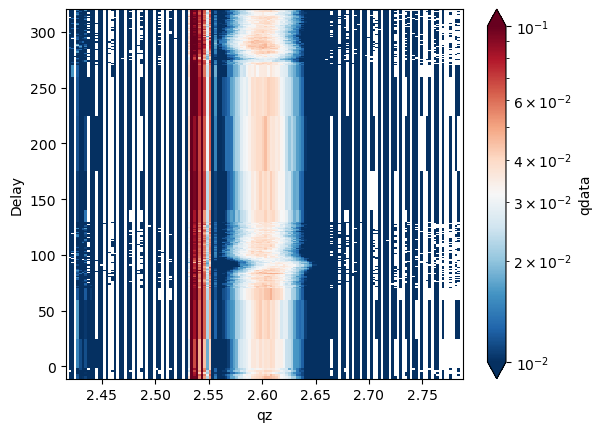

In [56]:
from matplotlib.colors import LogNorm
rsm.qdata.mean('qy').plot(norm=LogNorm(1e-2, 1e-1))

#### Spicing Things Up

This is example was the closest to a real-world application, and here we'll take
a moment to observe its developing complexity. Reviewing the `._cook(...)` method
there are some observations to me made:
- it's *rapidly* growing in complexity
- we've already had to make some decisions for simplificatio
  (i.e. choosing a data reduction factor, choosing 2 of the 3
  Q-space axes that we're interested in retaining, hard-coding
  the detector distance, choosing a suitable Q grid size...)

We find ourselves in the lucky situation that there's only *one* scan to
process. But actually, `UdkmScan` was supposed to be more universtal than that --
it was supposed to be able to process dozens of slightly different scans of
the same experiment!
This means that we need a way for the parameters we've hardcoded to be
supplied on a per-scan basis. And [spice is our mechanism](../../concepts.md).

Spice can be managed on the `udkm.p20210205` proposal level, directly in-memory.
We'll introduce a `settings` spice dictionary for that, with some
of the parameters we've previously hardcoded:

In [39]:
udkm.p20210205.spice.seed(
    'settings',
    img_center=(50, 120),
    img_distance=690.0,
    grid_size=(70, 140)
)

{'version': 'kmc3/1a',
 'type': 'settings',
 'handle': 'settings',
 'uuid': 'f33647c0-f399-4bb9-8d73-875d6479f940',
 'revision': 1,
 'anchor': '',
 'data': {'img_center': (50, 120),
  'img_distance': 690.0,
  'grid_size': (80, 150)}}

We can now verify that the spice view of our scan **091726** contains
the new settings:

In [40]:
udkm.p20210205.spice.view('r091726')

SpiceView({'settings': BranchView<settings:1>(img_center=(50, 120), img_distance=690.0, grid_size=(80, 150))})

And all we'd have to do now is rewrite `UdkmScan._cook(...)` to make use
of the new `settings` spice type:

In [41]:
def _rsm_settings(**spice):
    if 'settings' not in spice:
        raise RuntimeError('no settings in spice')

    print('settings from spice')

    return RsmSettings(
        spice['settings'].img_center,
        spice['settings'].grid_size,
        spice['settings'].img_distance
    )

...and now, cooking outght to take place using our modifyable spice data
(note the updated size of the Q-space grid):

In [43]:
rsm = udkm.p20210205.r091726.cooked
rsm

settings from spice


<xarray.Dataset> Size: 12MB
Dimensions:  (Delay: 122, qy: 80, qz: 150)
Coordinates:
  * qy       (qy) float64 640B -0.04778 -0.04653 -0.04528 ... 0.04958 0.05083
  * qz       (qz) float64 1kB 2.418 2.42 2.423 2.425 ... 2.779 2.782 2.784 2.787
  * Delay    (Delay) float64 976B -10.0 -8.0 -6.0 -4.0 ... 318.0 319.0 320.0
Data variables:
    qdata    (Delay, qy, qz) float64 12MB -1.173 0.0 -0.002105 ... 0.0 -1.218

From here on, the whole might of [spice management](../spice-man/)
is at our disposal to help us fine-tune processing for *any* scan
of the `UdkmDataScan` family.

### H5-Like Array-Based Formats